In [48]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn import metrics
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import sqlite3
import pandas as pd
import json

In [49]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


In [50]:
 
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))
nltk_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Yourui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [51]:
from io import StringIO
from html.parser import HTMLParser
from bs4 import BeautifulSoup

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def get_latex_from_alt(context):
    strip_deliminators = lambda latex: latex.replace('$','').replace('\\[','').replace('\\]','')

    context_soup = BeautifulSoup(context)
    latex_images = context_soup.find_all('img')
    for image in latex_images:
        image.replace_with(strip_deliminators(image['alt']))
    # return [strip_deliminators(image['alt']) for image in latex_images]
    return str(context_soup)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def remove_stopwords(text):
    filtered_text = [w for w in text.split() if w.lower() not in nltk_stopwords]
    return " ".join(filtered_text)

In [52]:
get_latex_from_alt('<html><head></head><body><p>In the following list of numbers, the integer <img alt=\"$n$\" class=\"latex\" height=\"8\" src=\"//latex.artofproblemsolving.com/1/7/4/174fadd07fd54c9afe288e96558c92e0c1da733a.png\" width=\"10\"/> appears <img alt=\"$n$\" class=\"latex\" height=\"8\" src=\"//latex.artofproblemsolving.com/1/7/4/174fadd07fd54c9afe288e96558c92e0c1da733a.png\" width=\"10\"/> times in the list for <img alt=\"$1 \\leq n \\leq 200$\" class=\"latex\" height=\"15\" src=\"//latex.artofproblemsolving.com/9/1/7/917e3430450e9049864739d088103bef0598a899.png\" style=\"vertical-align: -2px\" width=\"95\"/>.<img alt=\"\\[1, 2, 2, 3, 3, 3, 4, 4, 4, 4, \\ldots, 200, 200, \\ldots , 200\\]\" class=\"latexcenter\" height=\"16\" src=\"//latex.artofproblemsolving.com/f/4/f/f4f50e6ad3c33b14e7352b50ecc5ff8322c37702.png\" width=\"332\"/>What is the median of the numbers in this list?\n</p><p>\n</p></body></html>')
remove_stopwords('value x satisfies x- \\frac{3}{4} = \\frac{5}{12} - \\frac{1}{3}? Adding \\frac{3}{4} sides, x= \\frac{5}{12} - \\frac{1}{3} + \\frac{3}{4} = \\frac{5}{12} - \\frac{4}{12} + \\frac{9}{12}=\\boxed{\\textbf{(E) }\\frac{5}{6}}. Multiplying 12 sides gets us 12x-9=1 \\Rightarrow 12x=10, therefore \\boxed{x=\\textbf{(E)}~\\frac{5}{6}}. \\ {-}\\frac{2}{3} \\ \\frac{7}{36} \\ \\frac{7}{12} \\ \\frac{2}{3} \\ \\frac{5}{6}')

'value x satisfies x- \\frac{3}{4} = \\frac{5}{12} - \\frac{1}{3}? Adding \\frac{3}{4} sides, x= \\frac{5}{12} - \\frac{1}{3} + \\frac{3}{4} = \\frac{5}{12} - \\frac{4}{12} + \\frac{9}{12}=\\boxed{\\textbf{(E) }\\frac{5}{6}}. Multiplying 12 sides gets us 12x-9=1 \\Rightarrow 12x=10, therefore \\boxed{x=\\textbf{(E)}~\\frac{5}{6}}. \\ {-}\\frac{2}{3} \\ \\frac{7}{36} \\ \\frac{7}{12} \\ \\frac{2}{3} \\ \\frac{5}{6}'

In [53]:
con = sqlite3.connect('site/amc10_problems.db')

cursor = con.cursor()
cursor.execute('SELECT * FROM problem')

problems_data = pd.DataFrame(cursor.fetchall(), columns=['id','test','number','choices','problem','answer','solutions','labels','difficulty'])

In [54]:
problems_data['test'] = problems_data['test'].apply(json.loads)
problems_data['solutions'] = problems_data['solutions'].apply(lambda x: " ".join([solution for solution in json.loads(x) 
                                                                                    if 'http' not in solution]))
problems_data['year'] = problems_data['test'].apply(lambda x: str(x[0]))
problems_data['instance'] = problems_data['test'].apply(lambda x: x[2])

problems_data.head(5)

,id,test,number,choices,problem,answer,solutions,labels,difficulty,year,instance
0,1,"[2015, 10, A]",1,"[""\\ -125"", ""\\ -120"", ""\\ \\frac{1}{5}"", ""\\ ...",<html><head></head><body><p>What is the value ...,C,"<p><img alt=""$(2^0-1+5^2-0)^{-1}\times5 = (1-1...",None,1,2015,A
1,2,"[2015, 10, A]",2,"[""\\ 3"", ""\\ 5"", ""\\ 7"", ""\\ 9"", ""\\ 11""]",<html><head></head><body><p>A box contains a c...,D,"<p>Let <img alt=""$a$"" class=""latex"" height=""8""...",None,1,2015,A
2,3,"[2015, 10, A]",3,"[""\\ 9"", ""\\ 18"", ""\\ 20"", ""\\ 22"", ""\\ 24""]",<html><head></head><body><p>Ann made a <img al...,D,"<p>We can see that a <img alt=""$1$"" class=""lat...",None,1,2015,A
3,4,"[2015, 10, A]",4,"[""\\ \\frac{1}{12}"", ""\\ \\frac{1}{6}"", ""\\ \\...","<html><head></head><body><p>Pablo, Sofia, and ...",B,<p>Assign a variable to the number of eggs Mia...,None,1,2015,A
4,5,"[2015, 10, A]",5,"[""\\ 81"", ""\\ 85"", ""\\ 91"", ""\\ 94"", ""\\ 95""]",<html><head></head><body><p>Mr. Patrick teache...,E,"<p>If the average of the first <img alt=""$14$""...",None,1,2015,A


In [55]:
problems_data['year'].unique()

array(['2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2021_Fall', '2022'], dtype=object)

In [56]:
problems_data = problems_data[problems_data['year'].isin(['2020', '2021_Fall', '2021', '2022'])]
problems_data.set_index('id')

,test,number,choices,problem,answer,solutions,labels,difficulty,year,instance
id,,,,,,,,,,
250,"[2020, 10, A]",1,"[""\\ {-}\\frac{2}{3}"", ""\\ \\frac{7}{36}"", ""\\...",<html><head></head><body><p>What value of <img...,E,"<p>Adding <img alt=""$\frac{3}{4}$"" class=""late...",None,1,2020,A
251,"[2020, 10, A]",2,"["" 0 "", "" 15 "", "" 30 "", "" 45 "", "" 60""]",<html><head></head><body><p>The numbers <img a...,C,<p>The arithmetic mean of the numbers <img alt...,None,1,2020,A
252,"[2020, 10, A]",3,"["" {-}1 "", "" 1 "", "" \\frac{abc}{60} "", "" \\...",<html><head></head><body><p>Assuming <img alt=...,A,"<p>If <img alt=""$x\neq y,$"" class=""latex"" heig...",None,1,2020,A
253,"[2020, 10, A]",4,"[""\\ 20"", ""\\ 22"", ""\\ 24"", ""\\ 25"", ""\\ 26""]",<html><head></head><body><p>A driver travels f...,E,"<p>Since the driver travels <img alt=""$60$"" cl...",None,1,2020,A
254,"[2020, 10, A]",5,"["" 12 "", "" 15 "", "" 18 "", "" 21 "", "" 25""]",<html><head></head><body><p>What is the sum of...,C,"<p>Split the equation into two cases, where th...",None,1,2020,A
...,...,...,...,...,...,...,...,...,...,...
445,"[2022, 10, B]",21,"[""\\ 10 "", ""\\ 13 "", ""\\ 19 "", ""\\ 20 "", ""\\ 23""]","<html><head></head><body><p>Let <img alt=""$P(x...",E,<p>Given that all the answer choices and coeff...,None,5,2022,B
446,"[2022, 10, B]",22,"[""~48\\pi"", ""~68\\pi"", ""~96\\pi"", ""~102\\pi"", ...","<html><head></head><body><p>Let <img alt=""$S$""...",E,"<p><img alt=""[asy] import geometry; ...",None,5,2022,B
447,"[2022, 10, B]",23,"[""\\frac{1}{3} "", ""\\frac{1}{2} "", ""\\frac{2...",<html><head></head><body><p>Ant Amelia starts ...,C,"<p>Let <img alt=""$x$"" class=""latex"" height=""8""...",None,5,2022,B


In [57]:
labeled_data = pd.read_csv('problem_labels.csv').replace([True,False],[1,0])
labeled_data.shape

(250, 85)

In [58]:
labeled_data

,Year,Level,Instance,Problem,Arithmetic,Word Problems,Fractions/Percentages,Tracing,Strategy/Answer Choices,Exponentiation/nth Roots,...,Placing/Picking/Labeling Problems,Stars and Bars,Expected Value,Recursive Counting,Conditional Probability,Pigeonhole Principle,Complementary Counting,States,Principle of Inclusion-Exclusion,Geometric Probability
0,2022,10,A,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022,10,A,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022,10,A,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022,10,A,4,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022,10,A,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2019,10,B,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,2019,10,B,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
247,2019,10,B,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248,2019,10,B,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
misc_labels = (4,23)
alg_labels = (23,44)
geo_labels = (44,60)
nt_labels = (60,68)
cb_labels = (68,85)

def extract_labels(cols):
    start, end = cols
    return labeled_data[labeled_data.columns[start:end]].values.tolist()

In [60]:
labeled_data['misc-labels'] = extract_labels(misc_labels)
labeled_data['alg-labels'] = extract_labels(alg_labels)
labeled_data['geo-labels'] = extract_labels(geo_labels)
labeled_data['nt-labels'] = extract_labels(nt_labels)
labeled_data['cb-labels'] = extract_labels(cb_labels)

labeled_data['Miscellaneous'] = labeled_data['misc-labels'].apply(lambda x: int(any(x)))
labeled_data['Combinatorics'] = labeled_data['cb-labels'].apply(lambda x: int(any(x)))

In [61]:
labeled_data

,Year,Level,Instance,Problem,Arithmetic,Word Problems,Fractions/Percentages,Tracing,Strategy/Answer Choices,Exponentiation/nth Roots,...,States,Principle of Inclusion-Exclusion,Geometric Probability,misc-labels,alg-labels,geo-labels,nt-labels,cb-labels,Miscellaneous,Combinatorics
0,2022,10,A,1,1,0,1,0,0,0,...,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
1,2022,10,A,2,1,1,0,0,0,0,...,0,0,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
2,2022,10,A,3,0,1,0,0,0,0,...,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
3,2022,10,A,4,0,1,1,0,0,0,...,0,0,0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
4,2022,10,A,5,0,0,0,0,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2019,10,B,21,0,0,0,0,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1
246,2019,10,B,22,0,0,0,0,0,0,...,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0,1
247,2019,10,B,23,0,0,0,0,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
248,2019,10,B,24,0,0,0,0,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0


In [62]:
labeled_data['tl-labels'] = labeled_data[['Miscellaneous','Algebra','Geometry','Number Theory','Combinatorics']].values.tolist()

labeled_data = labeled_data[['Year','Instance','Problem',
                             'Miscellaneous','Algebra','Geometry','Number Theory','Combinatorics',
                             'misc-labels','alg-labels','geo-labels','nt-labels','cb-labels','tl-labels',]]
labeled_data

,Year,Instance,Problem,Miscellaneous,Algebra,Geometry,Number Theory,Combinatorics,misc-labels,alg-labels,geo-labels,nt-labels,cb-labels,tl-labels
0,2022,A,1,1,1,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0]"
1,2022,A,2,1,0,0,0,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]"
2,2022,A,3,1,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]"
3,2022,A,4,1,1,0,0,0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0]"
4,2022,A,5,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2019,B,21,1,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1]"
246,2019,B,22,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 1]"
247,2019,B,23,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0]"
248,2019,B,24,1,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]"


In [63]:
problems_data = problems_data[['year','instance','number','choices','problem','solutions']]
problems_data['problem'] = problems_data['problem'].map(lambda x: strip_tags(get_latex_from_alt(x)))
problems_data['solutions'] = problems_data['solutions'].map(lambda x: strip_tags(get_latex_from_alt(x)))
problems_data['choices'] = problems_data['choices'].map(lambda x: ' '.join(json.loads(x)))
problems_data['context'] = problems_data['problem'] + problems_data['solutions'] + problems_data['choices'] 
problems_data['context'] = problems_data['context'].map(remove_stopwords)
problems_data.drop(columns=['problem','choices','solutions'],inplace=True)
labeled_data.rename(columns={'Year':'year', 'Instance':'instance', 'Problem':'number'}, inplace=True)

/var/folders/h1/88vswkjs65x3v7m1ytlwgpy40000gp/T/ipykernel_93191/2196254196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data.rename(columns={'Year':'year', 'Instance':'instance', 'Problem':'number'}, inplace=True)


In [64]:
problems_data = problems_data.merge(right=labeled_data,on=['year','instance','number'])
problems_data

,year,instance,number,context,Miscellaneous,Algebra,Geometry,Number Theory,Combinatorics,misc-labels,alg-labels,geo-labels,nt-labels,cb-labels,tl-labels
0,2020,A,1,value x satisfies x- \frac{3}{4} = \frac{5}{12...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0]"
1,2020,A,2,"numbers 3, 5, 7, a, b average (arithmetic mean...",1,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0]"
2,2020,A,3,"Assuming a\neq3, b\neq4, c\neq5, value simples...",0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0]"
3,2020,A,4,"driver travels 2 hours 60 miles per hour, car ...",0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0]"
4,2020,A,5,sum real numbers x |x^2-12x+34|=2? Split equat...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022,B,21,Let P(x) polynomial rational coefficients P(x)...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0]"
196,2022,B,22,Let set circles coordinate plane tangent three...,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0]"
197,2022,B,23,Ant Amelia starts number line 0 crawls followi...,1,0,0,0,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1]"
198,2022,B,24,Consider functions f satisfy |f(x)-f(y)|\leq \...,1,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0]"


In [65]:
problems_data['context'].iloc[0]

'value x satisfies x- \\frac{3}{4} = \\frac{5}{12} - \\frac{1}{3}? Adding \\frac{3}{4} sides, x= \\frac{5}{12} - \\frac{1}{3} + \\frac{3}{4} = \\frac{5}{12} - \\frac{4}{12} + \\frac{9}{12}=\\boxed{\\textbf{(E) }\\frac{5}{6}}. Multiplying 12 sides gets us 12x-9=1 \\Rightarrow 12x=10, therefore \\boxed{x=\\textbf{(E)}~\\frac{5}{6}}. \\ {-}\\frac{2}{3} \\ \\frac{7}{36} \\ \\frac{7}{12} \\ \\frac{2}{3} \\ \\frac{5}{6}'

In [66]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 1e-05

In [67]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',truncation_side='left',truncation=True)
tokenizer.add_tokens(list(open('latex-vocabulary/latex_symbols.txt','r')))

13855

In [68]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, labels, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['context']
        self.targets = dataframe[labels]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [69]:
train_size = 0.8
training_data = problems_data.sample(frac=train_size, random_state=200).reset_index(drop=True)
validation_data = problems_data.drop(training_data.index).reset_index(drop=True)

In [70]:
training_dataset = MultiLabelDataset(training_data, tokenizer, 'tl-labels', MAX_LEN)
val_dataset = MultiLabelDataset(validation_data, tokenizer, 'tl-labels', MAX_LEN)

In [71]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_dataset, **train_params)
testing_loader = DataLoader(val_dataset, **test_params)

In [72]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        return self.classifier(pooler)

In [73]:
top_level_model = DistilBERTClass(num_classes=5)
top_level_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [74]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [75]:
optimizer = torch.optim.Adam(params =  top_level_model.parameters(), lr=LEARNING_RATE)

In [76]:
class ModelTraining:
    def __init__(self, model, training_loader, testing_loader, optimizer):
        self.model = model
        self.training_loader = training_loader
        self.optimizer = optimizer
        self.testing_loader = testing_loader
    
    def train_model(self,epoch):
        self.model.train()
        for _, data in enumerate(self.training_loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            
            outputs = self.model(ids, mask)

            self.optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            if _%1000==0:
                print(f'Epoch: {epoch}, Loss: {loss.item()}')
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def validation(self):
        self.model.eval()
        fin_targets=[]
        fin_outputs=[]
        with torch.no_grad():
            for _, data in enumerate(self.testing_loader):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = self.model(ids, mask)
                fin_targets.extend(targets.cpu().detach().numpy().tolist())
                fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        return fin_outputs, fin_targets

In [77]:
tl_model_trainer = ModelTraining(top_level_model,training_loader,testing_loader,optimizer)
for epoch in range(EPOCHS):
    tl_model_trainer.train_model(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.7106960415840149
Epoch: 1, Loss: 0.5558343529701233
Epoch: 2, Loss: 0.5960198044776917
Epoch: 3, Loss: 0.67167067527771
Epoch: 4, Loss: 0.5416795611381531
Epoch: 5, Loss: 0.5711085200309753
Epoch: 6, Loss: 0.5323193669319153
Epoch: 7, Loss: 0.6082505583763123
Epoch: 8, Loss: 0.49381664395332336
Epoch: 9, Loss: 0.3613772392272949
Epoch: 10, Loss: 0.3556414544582367
Epoch: 11, Loss: 0.4301281273365021
Epoch: 12, Loss: 0.28139930963516235
Epoch: 13, Loss: 0.3533804714679718
Epoch: 14, Loss: 0.17613485455513
Epoch: 15, Loss: 0.2364993393421173
Epoch: 16, Loss: 0.2005327194929123
Epoch: 17, Loss: 0.17313939332962036
Epoch: 18, Loss: 0.1499621570110321
Epoch: 19, Loss: 0.11899769306182861
Epoch: 20, Loss: 0.08581982553005219
Epoch: 21, Loss: 0.12126216292381287
Epoch: 22, Loss: 0.10434545576572418
Epoch: 23, Loss: 0.11335748434066772
Epoch: 24, Loss: 0.06625279039144516
Epoch: 25, Loss: 0.07853897660970688
Epoch: 26, Loss: 0.0657394528388977
Epoch: 27, Loss: 0.0803028270602

In [78]:
torch.save(top_level_model,'top-level-with-solutions-distilbert-amc10-2019-2022.pt')

In [79]:
# model = torch.load('top-level-distilbert-amc10-2020-2022.pt')

In [80]:
# def validation(testing_loader):
#     model.eval()
#     fin_targets=[]
#     fin_outputs=[]
#     with torch.no_grad():
#         for _, data in enumerate(testing_loader):
#             ids = data['ids'].to(device, dtype = torch.long)
#             mask = data['mask'].to(device, dtype = torch.long)
#             # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
#             targets = data['targets'].to(device, dtype = torch.float)
#             outputs = top_level_model(ids, mask)
#             fin_targets.extend(targets.cpu().detach().numpy().tolist())
#             fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
#     return fin_outputs, fin_targets

Accuracy Score = 0.875
F1 Score (Micro) = 0.9310344827586206
F1 Score (Macro) = 0.9188971903609386


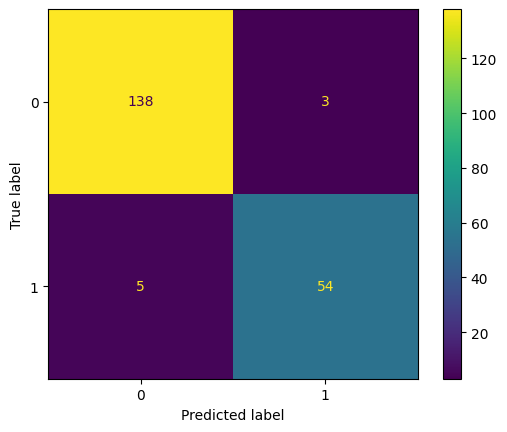

In [81]:
from itertools import chain

outputs, targets = tl_model_trainer.validation()

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(chain.from_iterable(targets)),
                                                             list(chain.from_iterable(outputs))))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [82]:
# for cm in metrics.multilabel_confusion_matrix(targets,outputs):
#     matrix = metrics.ConfusionMatrixDisplay(cm)
#     matrix.plot()
# single_label_accuracy = metrics.accuracy_score(list(chain.from_iterable(targets)), list(chain.from_iterable(outputs)))
# print(f"Single-label Accuracy Score = {single_label_accuracy}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


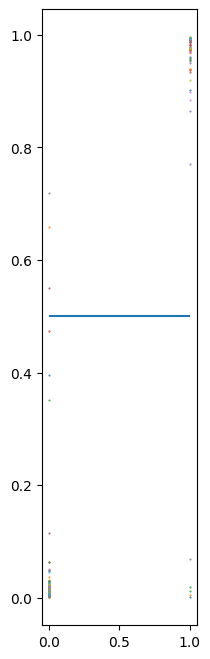

In [83]:
outputs, targets = tl_model_trainer.validation()

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()

In [84]:
def generate_model(dataframe, labels):
    training_data = dataframe.sample(frac=train_size, random_state=200).reset_index(drop=True)
    validation_data = dataframe.drop(training_data.index).reset_index(drop=True)

    training_dataset = MultiLabelDataset(training_data, tokenizer, labels, MAX_LEN)
    val_dataset = MultiLabelDataset(validation_data, tokenizer, labels, MAX_LEN)

    training_loader = DataLoader(training_dataset, **train_params)
    testing_loader = DataLoader(val_dataset, **test_params)

    model = DistilBERTClass(len(dataframe[labels].iloc[0]))
    model.to(device)

    return model, training_loader, testing_loader

In [85]:
alg_data = problems_data.loc[problems_data['Algebra'] == True]
alg_data = alg_data[['year','instance','number','context','alg-labels']].reset_index()
alg_data

,index,year,instance,number,context,alg-labels
0,0,2020,A,1,value x satisfies x- \frac{3}{4} = \frac{5}{12...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,2020,A,2,"numbers 3, 5, 7, a, b average (arithmetic mean...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,2020,A,3,"Assuming a\neq3, b\neq4, c\neq5, value simples...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,2020,A,4,"driver travels 2 hours 60 miles per hour, car ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
4,4,2020,A,5,sum real numbers x |x^2-12x+34|=2? Split equat...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,7,2020,A,8,value 1+2+3-4+5+6+7-8+\cdots+197+198+199-200? ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,8,2020,A,9,single bench section school event hold either ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,13,2020,A,14,Real numbers x satisfy x + = 4 x \cdot = -2. v...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,20,2020,A,21,exists unique strictly increasing sequence non...,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
9,21,2020,A,22,many positive integers n \le 1000 is\left\lflo...,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [86]:
alg_model, alg_training_loader, alg_testing_loader = generate_model(alg_data, 'alg-labels')
alg_optimizer = torch.optim.Adam(params=alg_model.parameters(), lr=LEARNING_RATE)
alg_model_trainer = ModelTraining(alg_model, alg_training_loader, alg_testing_loader, alg_optimizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [87]:
for epoch in range(EPOCHS):
    alg_model_trainer.train_model(epoch)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.6950458884239197
Epoch: 1, Loss: 0.6419968605041504
Epoch: 2, Loss: 0.5866342186927795
Epoch: 3, Loss: 0.5295674204826355
Epoch: 4, Loss: 0.4910399615764618
Epoch: 5, Loss: 0.4679897725582123
Epoch: 6, Loss: 0.4577275216579437
Epoch: 7, Loss: 0.40935519337654114
Epoch: 8, Loss: 0.39786002039909363
Epoch: 9, Loss: 0.38704150915145874
Epoch: 10, Loss: 0.3490161895751953
Epoch: 11, Loss: 0.36012428998947144
Epoch: 12, Loss: 0.32536423206329346
Epoch: 13, Loss: 0.3287472426891327
Epoch: 14, Loss: 0.3410862982273102
Epoch: 15, Loss: 0.2934405207633972
Epoch: 16, Loss: 0.2854107916355133
Epoch: 17, Loss: 0.3389297127723694
Epoch: 18, Loss: 0.27125751972198486
Epoch: 19, Loss: 0.28185421228408813
Epoch: 20, Loss: 0.29248446226119995
Epoch: 21, Loss: 0.26890650391578674
Epoch: 22, Loss: 0.30532020330429077
Epoch: 23, Loss: 0.2683860957622528
Epoch: 24, Loss: 0.29399633407592773
Epoch: 25, Loss: 0.2601962685585022
Epoch: 26, Loss: 0.25563639402389526
Epoch: 27, Loss: 0.2246269

In [94]:
torch.save(alg_model,'algebra-model-distilbert-amc10-2019-2022.pt')

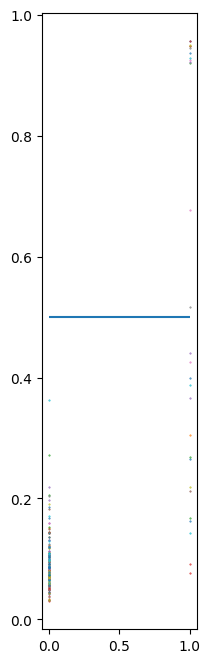

Accuracy Score = 0.935064935064935
Recall = 0.4642857142857143


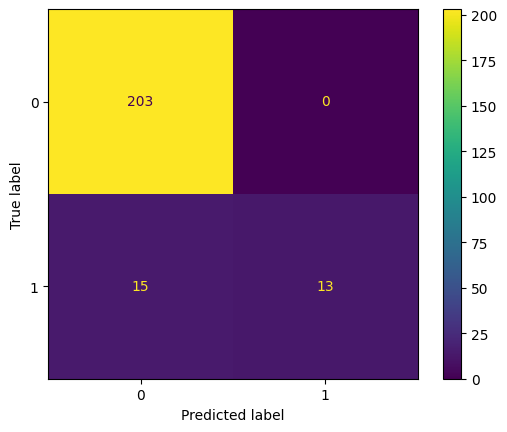

In [88]:
outputs, targets = alg_model_trainer.validation()



plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

targets = list(chain.from_iterable(targets))
outputs = list(chain.from_iterable(outputs))

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(targets,outputs))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
recall = metrics.recall_score(targets, outputs)

print(f"Accuracy Score = {accuracy}")
print(f"Recall = {recall}")

In [89]:
geo_data = problems_data.loc[problems_data['Geometry'] == True]
geo_data = geo_data[['year','instance','number','context','geo-labels']].reset_index()
geo_data

,index,year,instance,number,context,geo-labels
0,9,2020,A,10,"Seven cubes, whose volumes 1, 8, 27, 64, 125, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,11,2020,A,12,Triangle AMC isosceles = AC. Medians \overline...,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,15,2020,A,16,point chosen random within square coordinate p...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]"
3,19,2020,A,20,Quadrilateral ABCD satisfies \angle ABC = \ang...,"[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]"
4,22,2020,A,23,"Let triangle coordinate plane vertices (0,0), ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
5,26,2020,B,2,"Carl 5 cubes side length 1, Kate 5 cubes side ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,28,2020,B,4,acute angles right triangle a^{\circ} b^{\circ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,32,2020,B,8,Points P Q lie plane PQ=8. many locations poin...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
8,34,2020,B,10,three-quarter sector circle radius 4 inches to...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
9,37,2020,B,13,Andy Ant lives coordinate plane currently (-20...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [90]:
geo_model, geo_training_loader, geo_testing_loader = generate_model(geo_data, 'geo-labels')
geo_optimizer = torch.optim.Adam(params=geo_model.parameters(), lr=LEARNING_RATE)
geo_model_trainer = ModelTraining(geo_model, geo_training_loader, geo_testing_loader, geo_optimizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [91]:
for epoch in range(EPOCHS):
    geo_model_trainer.train_model(epoch)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.7095775008201599
Epoch: 1, Loss: 0.6468299031257629
Epoch: 2, Loss: 0.5938517451286316
Epoch: 3, Loss: 0.543269693851471
Epoch: 4, Loss: 0.5041046142578125
Epoch: 5, Loss: 0.48316872119903564
Epoch: 6, Loss: 0.4580364227294922
Epoch: 7, Loss: 0.4343108534812927
Epoch: 8, Loss: 0.4253767430782318
Epoch: 9, Loss: 0.3831723630428314
Epoch: 10, Loss: 0.42237886786460876
Epoch: 11, Loss: 0.3879419267177582
Epoch: 12, Loss: 0.3436622619628906
Epoch: 13, Loss: 0.34827956557273865
Epoch: 14, Loss: 0.32166266441345215
Epoch: 15, Loss: 0.3740878999233246
Epoch: 16, Loss: 0.3470425307750702
Epoch: 17, Loss: 0.38041314482688904
Epoch: 18, Loss: 0.36882615089416504
Epoch: 19, Loss: 0.35750359296798706
Epoch: 20, Loss: 0.33708319067955017
Epoch: 21, Loss: 0.36904090642929077
Epoch: 22, Loss: 0.3111971914768219
Epoch: 23, Loss: 0.305814266204834
Epoch: 24, Loss: 0.3112926483154297
Epoch: 25, Loss: 0.36859452724456787
Epoch: 26, Loss: 0.289310485124588
Epoch: 27, Loss: 0.294209063053

In [95]:
torch.save(top_level_model,'geometry-model-distilbert-amc10-2019-2022.pt')

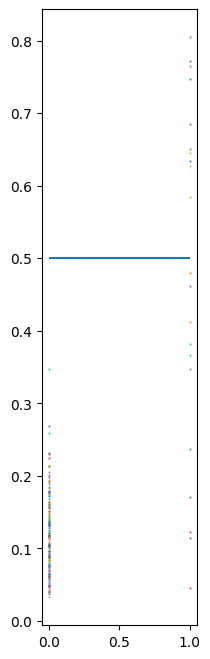

Accuracy Score = 0.9375
Recall = 0.47619047619047616


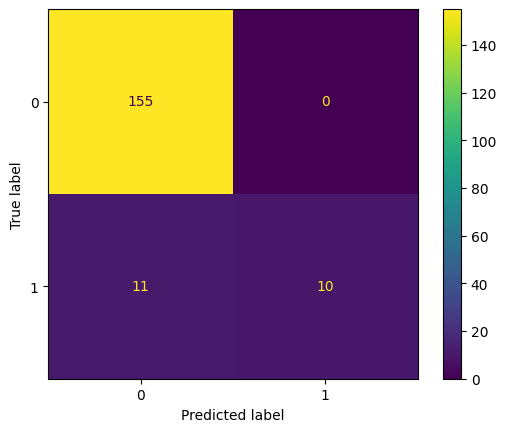

In [92]:
outputs, targets = geo_model_trainer.validation()

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

targets = list(chain.from_iterable(targets))
outputs = list(chain.from_iterable(outputs))

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(targets,outputs))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
recall = metrics.recall_score(targets, outputs)

print(f"Accuracy Score = {accuracy}")
print(f"Recall = {recall}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


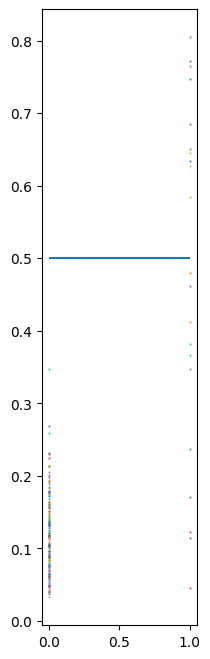

In [93]:
outputs, targets = geo_model_trainer.validation()

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()